<a href="https://colab.research.google.com/github/BweepBwop/Forensics-Plate-Number-Detection-using-Flask/blob/main/Copy_of_PlateNumberIdentifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install tensorflow

In [ ]:
!pip install easyocr
!pip install imutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 21.9 MB/s eta 0:00:00


Saving image2.jpg to image2 (2).jpg


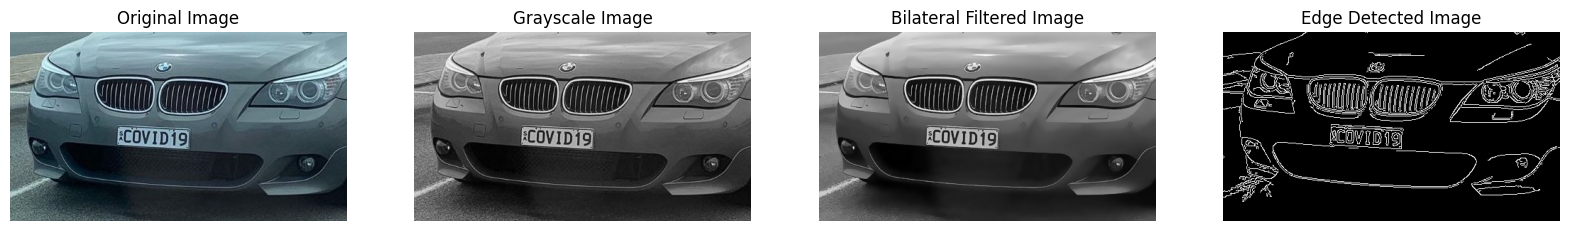

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, TensorDataset, DataLoader
import cv2
from google.colab import files

def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        return filename

uploaded_image_path = upload_image()

img = cv2.imread(uploaded_image_path)
if img is not None:

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply bilateral filter for noise reduction
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)

    # Perform edge detection using Canny
    edged = cv2.Canny(bfilter, 30, 200)

    # Create a figure to display all four images
    plt.figure(figsize=(20, 5))

    # Display the original image
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Display the grayscale image
    plt.subplot(1, 4, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')

    # Display the bilateral filtered image
    plt.subplot(1, 4, 3)
    plt.imshow(bfilter, cmap='gray')
    plt.title('Bilateral Filtered Image')
    plt.axis('off')

    # Display the edge-detected image
    plt.subplot(1, 4, 4)
    plt.imshow(edged, cmap='gray')
    plt.title('Edge Detected Image')
    plt.axis('off')

    plt.show()
else:
    print("Error: Image not found or unable to load.")

In [ ]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [ ]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

location

array([[[152, 136]],

       [[248, 139]],

       [[251, 164]],

       [[153, 160]]], dtype=int32)

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

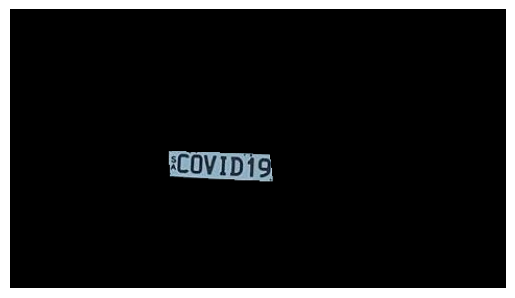

In [ ]:
plt.axis('off')
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

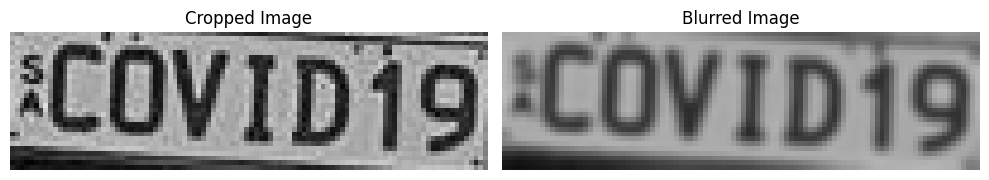

In [ ]:
blurred_image = cv2.GaussianBlur(cropped_image, (5, 5), 0)
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
# enhanced_image = clahe.apply(blurred_image)

# Step 3: Set up the plot for side-by-side comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Cropped Image')
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

# Display edges on the right
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Blurred Image')
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))

# # Display edges on the right
# plt.subplot(1, 3, 3)
# plt.axis('off')
# plt.title('Enhanced Image')
# plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))

# Show the comparison
plt.tight_layout()
plt.show()

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(blurred_image)
result

[([[0, 0], [100, 0], [100, 29], [0, 29]], "'COVID19", 0.9309959494373045)]

Detected Plate number: ["'COVID19"]


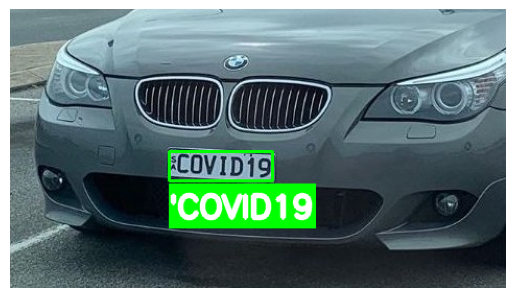

In [ ]:
detected_texts = [res[1] for res in result]
print("Detected Plate number:", detected_texts)

# Ensure that there is at least one detected text
if detected_texts:
    text = detected_texts[0]  # Use the first detected text as the license plate number
else:
    print("No detected text found.")
    text = "UNKNOWN"  # Default text if no plate is detected

font = cv2.FONT_HERSHEY_SIMPLEX
text_position = (approx[0][0][0], approx[1][0][1] + 60)

(text_width, text_height), baseline = cv2.getTextSize(text, font, fontScale=1, thickness=2)

rectangle_start = (text_position[0], text_position[1] - text_height - 10)
rectangle_end = (text_position[0] + text_width, text_position[1] + baseline)

res = cv2.rectangle(img, rectangle_start, rectangle_end, (0, 255, 0), thickness=cv2.FILLED)

res = cv2.putText(res, text=text, org=text_position, fontFace=font, fontScale=1, color=(255, 255, 255), thickness=3, lineType=cv2.LINE_AA)

# Draw a rectangle around the detected license plate
res = cv2.rectangle(res, tuple(approx[0][0]), tuple(approx[2][0]), (0, 255, 0), 2)

# Display using matplotlib
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()